# Model Training (Scaled)
Semantica is a prediction engine that categorizes issues based on the text content. This notebook explores various machine learning models against the entire dataset for training viability.

## Environment setup and imports
This section installs required libraries (if missing) and imports common utilities for data handling, visualization, embeddings, and modeling. If internet access is unavailable for model downloads, the notebook will gracefully skip BERT embeddings and proceed with TF-IDF features.


In [ ]:
import os
import re
import json
import warnings
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Load dataset and quick EDA
Load the refined dataset and perform a light exploratory pass to confirm schema, basic distributions, and potential missing values. We’ll also preview lengths of `title` and `body` to inform downstream feature engineering.


In [ ]:
df = pd.read_csv("github_issues_single_label.csv")
print("Shape:", df.shape)
df.head(3)


Shape: (15955, 3)


,title,body,label
0,Article mistake,### Describe the problem that you experienced\...,help wanted
1,Able to change the window height even if IsRes...,### Describe the bug\n\nIf you set ExtendsCont...,bug
2,Introduce local for 'this' is not very useful,**Version Used**: VS 15.7\r\n\r\n**Steps to Re...,Bug


In [3]:
# Basic info and missing values
df.info()
print("\nMissing values per column:\n", df.isna().sum())

# Quick text length preview
lengths = pd.DataFrame({
    "title_len": df["title"].fillna("").str.len(),
    "body_len": df["body"].fillna("").str.len(),
})
lengths.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15955 entries, 0 to 15954
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   15955 non-null  object
 1   body    15955 non-null  object
 2   label   15946 non-null  object
dtypes: object(3)
memory usage: 374.1+ KB

Missing values per column:
 title    0
body     0
label    9
dtype: int64


,count,mean,std,min,25%,50%,75%,max
title_len,15955.0,55.288875,23.515959,3.0,39.0,53.0,68.0,466.0
body_len,15955.0,764.533250,386.744154,46.0,466.0,730.0,1026.5,2681.0


## Explore labels and define adjustable mapping
We inspect unique labels and frequencies, then define a flexible mapping from raw `label` to the five target categories: `bug`, `help wanted`, `documentation`, `enhancement`, and `other`. The mapping combines:
- a curated dictionary of common GitHub label names
- keyword/rule-based fallbacks

The mapping is designed to be easily adjusted by editing a dictionary and simple keyword lists.


In [4]:
# Unique labels and top frequencies
label_series = df["label"].astype(str).str.strip().str.lower()
value_counts = label_series.value_counts()
print("Num unique labels:", value_counts.shape[0])
value_counts.head(20)


Num unique labels: 336


label
bug                              12865
enhancement                        540
documentation                      357
good first issue                   211
help wanted                        155
waiting for customer response      133
type: bug                           81
type/bug                            74
issue: ready for work               57
no code attached yet                57
bug 🐛                               42
issue: confirmed                    41
issue: bug                          37
kind:bug                            36
type: docs                          36
docs                                35
t: bug                              32
question                            31
issue: enhancement                  26
easy                                25
Name: count, dtype: int64

In [ ]:
CURATED_LABEL_MAP: Dict[str, str] = {
    # bug-like
    "bug": "bug",
    "type: bug": "bug",
    "kind: bug": "bug",
    "priority: bug": "bug",
    "defect": "bug",
    "regression": "bug",
    
    # help wanted / needs assistance
    "help wanted": "help wanted",
    "good first issue": "help wanted",
    "good-first-issue": "help wanted",
    "first-timers-only": "help wanted",
    "beginner": "help wanted",
    
    # documentation
    "documentation": "documentation",
    "docs": "documentation",
    "doc": "documentation",
    "readme": "documentation",
    
    # enhancement / feature
    "enhancement": "enhancement",
    "feature": "enhancement",
    "feature request": "enhancement",
    "proposal": "enhancement",
    "improvement": "enhancement",
}

BUG_KEYWORDS = ["bug", "defect", "regression", "crash", "fails", "error", "exception"]
HELP_KEYWORDS = ["help wanted", "good first issue", "first-timers", "beginner", "starter"]
DOCS_KEYWORDS = ["docs", "documentation", "readme", "guide", "tutorial"]
ENH_KEYWORDS = ["enhancement", "feature", "proposal", "improvement", "rfe", "request"]

CATEGORY_SET = {"bug", "help wanted", "documentation", "enhancement", "other"}


def map_label_to_category(raw_label: Optional[str]) -> Optional[str]:
    if not isinstance(raw_label, str):
        return None
    lbl = raw_label.strip().lower()
    if lbl == "" or lbl in {"none", "nan"}:
        return None
    
    # 1) direct mapping
    if lbl in CURATED_LABEL_MAP:
        return CURATED_LABEL_MAP[lbl]
    
    # 2) keyword fallbacks
    for kw in BUG_KEYWORDS:
        if kw in lbl:
            return "bug"
    for kw in HELP_KEYWORDS:
        if kw in lbl:
            return "help wanted"
    for kw in DOCS_KEYWORDS:
        if kw in lbl:
            return "documentation"
    for kw in ENH_KEYWORDS:
        if kw in lbl:
            return "enhancement"
    
    return "other"

# Preview mapping on top labels
preview = pd.DataFrame({
    "label": value_counts.head(50).index,
})
preview["category"] = preview["label"].map(map_label_to_category)
preview


,label,category
0,bug,bug
1,enhancement,enhancement
2,documentation,documentation
3,good first issue,help wanted
4,help wanted,help wanted
5,waiting for customer response,other
6,type: bug,bug
7,type/bug,bug
8,issue: ready for work,other
9,no code attached yet,other


## Apply mapping and assess class balance
We create the `category` column from `label`, drop rows without a valid category, then inspect distribution to evaluate potential imbalance and the need for class weighting or resampling.


Dropped 9 rows without a valid category.
category
bug              13283
other              982
enhancement        784
documentation      510
help wanted        387
Name: count, dtype: int64


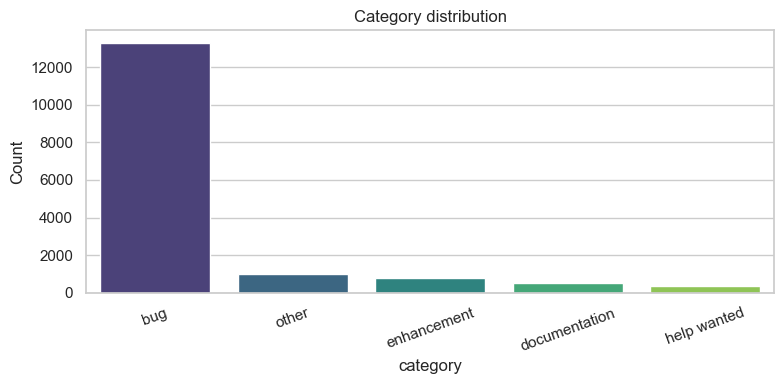

{'bug': np.float64(0.240096363773244),
 'documentation': np.float64(6.253333333333333),
 'enhancement': np.float64(4.067857142857143),
 'help wanted': np.float64(8.240826873385013),
 'other': np.float64(3.2476578411405295)}

In [6]:
df["category"] = df["label"].map(map_label_to_category)
before = df.shape[0]
df = df[~df["category"].isna()].copy()
after = df.shape[0]
print(f"Dropped {before - after} rows without a valid category.")

cat_counts = df["category"].value_counts()
print(cat_counts)

plt.figure(figsize=(8,4))
sns.barplot(x=cat_counts.index, y=cat_counts.values, palette="viridis")
plt.title("Category distribution")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Compute class weights for later modeling
classes = sorted(df["category"].unique())
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(classes),
    y=df["category"].values,
)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
class_weight_dict


## Feature engineering: heuristic text features
We add lightweight features that often correlate with issue types:
- `title_length`, `body_length`
- `has_one_question_mark`, `has_multiple_question_marks`
- `has_one_url`, `has_multiple_urls`
- `has_code_block`, `has_multiple_code_blocks`

All are derived from combined `title` + `body` text to mirror user-facing inputs.


In [7]:
def combine_text(row: pd.Series) -> str:
    title = (row.get("title") or "").strip()
    body = (row.get("body") or "").strip()
    return (title + "\n\n" + body).strip()

url_pattern = re.compile(r"https?://\S+")
code_fence_pattern = re.compile(r"```+\s*[\s\S]*?```+", flags=re.MULTILINE)


df["combined_text"] = df.apply(combine_text, axis=1)
df["title_length"] = df["title"].fillna("").str.len()
df["body_length"] = df["body"].fillna("").str.len()

qm_counts = df["combined_text"].str.count(r"\?")
df["has_multiple_question_marks"] = (qm_counts >= 2).astype(int)
df["has_one_question_mark"] = (qm_counts == 1).astype(int)

url_counts = df["combined_text"].apply(lambda x: len(url_pattern.findall(x or "")))
df["has_multiple_urls"] = (url_counts >= 2).astype(int)
df["has_one_url"] = (url_counts == 1).astype(int)

code_counts = df["combined_text"].apply(lambda x: len(code_fence_pattern.findall(x or "")))
df["has_multiple_code_blocks"] = (code_counts >= 2).astype(int)
df["has_code_block"] = (code_counts >= 1).astype(int)

df[[
    "title_length", "body_length",
    "has_one_question_mark", "has_multiple_question_marks",
    "has_one_url", "has_multiple_urls",
    "has_code_block", "has_multiple_code_blocks"
]].describe().T


,count,mean,std,min,25%,50%,75%,max
title_length,15946.0,55.289665,23.515965,3.0,39.0,53.0,68.00,466.0
body_length,15946.0,764.532422,386.730629,46.0,466.0,730.0,1026.75,2681.0
has_one_question_mark,15946.0,0.203876,0.402890,0.0,0.0,0.0,0.00,1.0
has_multiple_question_marks,15946.0,0.174652,0.379681,0.0,0.0,0.0,0.00,1.0
has_one_url,15946.0,0.307726,0.461567,0.0,0.0,0.0,1.00,1.0
has_multiple_urls,15946.0,0.314624,0.464381,0.0,0.0,0.0,1.00,1.0
has_code_block,15946.0,0.274740,0.446397,0.0,0.0,0.0,1.00,1.0
has_multiple_code_blocks,15946.0,0.088674,0.284282,0.0,0.0,0.0,0.00,1.0


## Text features: TF-IDF and optional BERT embeddings
We prepare two text representations of `combined_text`:
- TF-IDF n-grams for classical linear models
- BERT sentence embeddings (`all-MiniLM-L6-v2`) if available; gracefully skipped otherwise

These will be used in model selection alongside the heuristic features.


In [ ]:
TARGET = "category"
TEXT_COL = "combined_text"
AUX_FEATURES = [
    "title_length", "body_length",
    "has_one_question_mark", "has_multiple_question_marks",
    "has_one_url", "has_multiple_urls",
    "has_code_block", "has_multiple_code_blocks",
]

X_text = df[TEXT_COL].fillna("")
X_aux = df[AUX_FEATURES].astype(float)
y = df[TARGET].astype(str)

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    max_features=100_000,
)

bert_model = None
if _USE_BERT:
    try:
        bert_model = SentenceTransformer("all-MiniLM-L6-v2")
    except Exception as e:
        print("BERT embedding model unavailable, proceeding without it:", str(e))
        bert_model = None


## Model selection with cross-validation
We evaluate multiple classifiers using stratified 5-fold CV optimizing macro-F1:
- Text-only (TF-IDF) with LinearSVC and LogisticRegression
- Text + Aux features via `ColumnTransformer`
- Optional BERT embeddings + Aux features with LogisticRegression

Class weights are used where applicable to mitigate imbalance.


In [ ]:
from sklearn.preprocessing import FunctionTransformer
from scipy.sparse import hstack

X_all = pd.DataFrame({TEXT_COL: X_text})
for col in AUX_FEATURES:
    X_all[col] = X_aux[col].values

text_and_aux = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf_vectorizer, TEXT_COL),
        ("aux", "passthrough", AUX_FEATURES),
    ],
    remainder="drop",
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipelines = {
    "tfidf_linear_svc": Pipeline([
        ("tfidf", tfidf_vectorizer),
        ("clf", LinearSVC()),
    ]),
    "tfidf_logreg": Pipeline([
        ("tfidf", tfidf_vectorizer),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced")),
    ]),
    "tfidf_aux_logreg": Pipeline([
        ("features", text_and_aux),
        ("scale", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced")),
    ]),
}

if bert_model is not None:
    try:
        bert_embeddings = bert_model.encode(X_text.tolist(), show_progress_bar=True)
        X_bert_all = np.hstack([bert_embeddings, X_aux.values])
        pipelines["bert_aux_logreg"] = Pipeline([
            ("scale", StandardScaler()),
            ("clf", LogisticRegression(max_iter=300, class_weight="balanced")),
        ])
    except Exception as e:
        print("Skipping BERT due to error:", str(e))
        bert_model = None

results = []
for name, pipe in pipelines.items():
    try:
        if name.startswith("bert_"):
            scores = cross_val_score(
                pipe, X_bert_all, y, scoring="f1_macro", cv=cv, n_jobs=-1
            )
        elif name.startswith("tfidf_"):
            # For tfidf-only, pass text series
            if name in {"tfidf_linear_svc", "tfidf_logreg"}:
                scores = cross_val_score(
                    pipe, X_text, y, scoring="f1_macro", cv=cv, n_jobs=-1
                )
            else:
                scores = cross_val_score(
                    pipe, X_all, y, scoring="f1_macro", cv=cv, n_jobs=-1
                )
        else:
            scores = cross_val_score(
                pipe, X_all, y, scoring="f1_macro", cv=cv, n_jobs=-1
            )
        results.append({"model": name, "f1_macro_mean": scores.mean(), "f1_macro_std": scores.std()})
        print(f"{name}: F1-macro {scores.mean():.4f} ± {scores.std():.4f}")
    except Exception as e:
        print(f"{name}: error during CV ->", str(e))

results_df = pd.DataFrame(results).sort_values("f1_macro_mean", ascending=False)
results_df


Batches:   0%|          | 0/499 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

tfidf_linear_svc: F1-macro 0.5541 ± 0.0152
tfidf_logreg: F1-macro 0.5894 ± 0.0218
tfidf_aux_logreg: F1-macro 0.4839 ± 0.0170
bert_aux_logreg: F1-macro 0.3575 ± 0.0113


,model,f1_macro_mean,f1_macro_std
1,tfidf_logreg,0.589400,0.021847
0,tfidf_linear_svc,0.554141,0.015170
2,tfidf_aux_logreg,0.483853,0.017014
3,bert_aux_logreg,0.357529,0.011323


## Train best model and visualize results
We select the top-performing approach, fit on a holdout split, and report per-class precision/recall/F1 along with a confusion matrix to inspect error modes.


Best model by CV: tfidf_logreg

Classification report (holdout):
               precision    recall  f1-score   support

          bug      0.941     0.912     0.926      2657
documentation      0.485     0.637     0.551       102
  enhancement      0.430     0.611     0.505       157
  help wanted      0.471     0.416     0.441        77
        other      0.534     0.513     0.523       197

     accuracy                          0.852      3190
    macro avg      0.572     0.618     0.589      3190
 weighted avg      0.865     0.852     0.857      3190



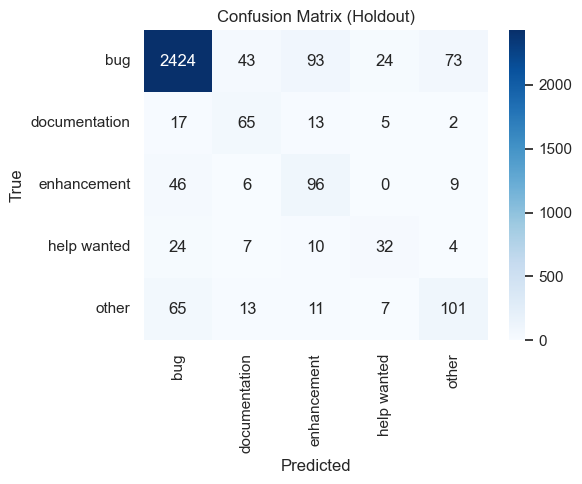

In [ ]:
assert not pd.isna(y).any()

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)
X_train_aux = X_aux.loc[X_train_text.index]
X_test_aux = X_aux.loc[X_test_text.index]

best_name = results_df.iloc[0]["model"] if len(results_df) else "tfidf_linear_svc"
print("Best model by CV:", best_name)

# Rebuild the chosen pipeline
if best_name == "tfidf_linear_svc":
    final_pipeline = Pipeline([
        ("tfidf", tfidf_vectorizer),
        ("clf", LinearSVC()),
    ])
    final_pipeline.fit(X_train_text, y_train)
    y_pred = final_pipeline.predict(X_test_text)

elif best_name == "tfidf_logreg":
    final_pipeline = Pipeline([
        ("tfidf", tfidf_vectorizer),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced")),
    ])
    final_pipeline.fit(X_train_text, y_train)
    y_pred = final_pipeline.predict(X_test_text)

elif best_name == "tfidf_aux_logreg":
    X_train_all = pd.DataFrame({TEXT_COL: X_train_text})
    for col in AUX_FEATURES:
        X_train_all[col] = X_train_aux[col].values
    X_test_all = pd.DataFrame({TEXT_COL: X_test_text})
    for col in AUX_FEATURES:
        X_test_all[col] = X_test_aux[col].values

    final_pipeline = Pipeline([
        ("features", text_and_aux),
        ("scale", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced")),
    ])
    final_pipeline.fit(X_train_all, y_train)
    y_pred = final_pipeline.predict(X_test_all)

elif best_name == "bert_aux_logreg" and bert_model is not None:
    X_train_bert = bert_model.encode(X_train_text.tolist(), show_progress_bar=True)
    X_test_bert = bert_model.encode(X_test_text.tolist(), show_progress_bar=True)
    X_train_bert_all = np.hstack([X_train_bert, X_train_aux.values])
    X_test_bert_all = np.hstack([X_test_bert, X_test_aux.values])

    final_pipeline = Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced")),
    ])
    final_pipeline.fit(X_train_bert_all, y_train)
    y_pred = final_pipeline.predict(X_test_bert_all)
else:
    # Fallback to TF-IDF LinearSVC
    final_pipeline = Pipeline([
        ("tfidf", tfidf_vectorizer),
        ("clf", LinearSVC()),
    ])
    final_pipeline.fit(X_train_text, y_train)
    y_pred = final_pipeline.predict(X_test_text)

print("\nClassification report (holdout):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Holdout)")
plt.tight_layout()
plt.show()


## Hyperparameter search: TF-IDF + classifiers (optimize macro-F1)
We tune TF-IDF and classifier parameters using 5-fold stratified CV on the training split. Models:
- LinearSVC (hinge loss, strong baseline for text)
- LogisticRegression (liblinear/saga)
We also test character n-grams and token n-grams, and TF-IDF min/max DF.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best params: {'clf': LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear'), 'clf__C': 2.0, 'tfidf__max_df': 0.85, 'tfidf__max_features': 50000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
Best CV macro-F1: 0.5801007657877889

Tuned model classification report (holdout):
               precision    recall  f1-score   support

          bug      0.912     0.967     0.939      2657
documentation      0.604     0.569     0.586       102
  enhancement      0.613     0.414     0.494       157
  help wanted      0.500     0.299     0.374        77
        other      0.650     0.406     0.500       197

     accuracy                          0.876      3190
    macro avg      0.656     0.531     0.579      3190
 weighted avg      0.861     0.876     0.865      3190



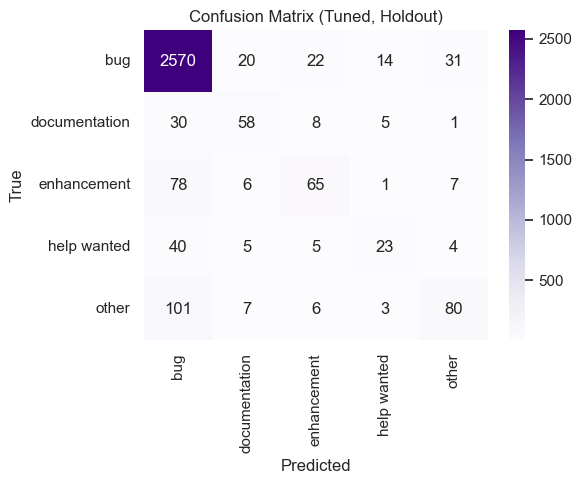

In [ ]:
from sklearn.model_selection import GridSearchCV

X_train_text, X_test_text, y_train, y_test

param_grid = [
    {
        "tfidf__ngram_range": [(1,1), (1,2)],
        "tfidf__min_df": [2, 5],
        "tfidf__max_df": [0.85, 0.9, 0.95],
        "tfidf__max_features": [50000, 100000],
        "clf": [LinearSVC()],
        "clf__C": [0.5, 1.0, 2.0],
    },
    {
        "tfidf__ngram_range": [(1,1), (1,2)],
        "tfidf__min_df": [2, 5],
        "tfidf__max_df": [0.85, 0.9, 0.95],
        "tfidf__max_features": [50000, 100000],
        "clf": [LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear")],
        "clf__C": [0.5, 1.0, 2.0],
    },
]

base_pipe = Pipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", LinearSVC()),
])

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
)

grid.fit(X_train_text, y_train)
print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

best_tuned = grid.best_estimator_
y_pred_tuned = best_tuned.predict(X_test_text)
print("\nTuned model classification report (holdout):")
print(classification_report(y_test, y_pred_tuned, digits=3))

cm_tuned = confusion_matrix(y_test, y_pred_tuned, labels=classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Purples", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Tuned, Holdout)")
plt.tight_layout()
plt.show()


## Error analysis: where does the model confuse classes?
Inspect most common confusion pairs and sample misclassifications to guide mapping/refinements and potential resampling.


In [ ]:
model_for_errors = best_tuned if 'best_tuned' in globals() else final_pipeline

preds = model_for_errors.predict(X_test_text)
err_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": preds,
    "title": df.loc[X_test_text.index, "title"].values,
    "body": df.loc[X_test_text.index, "body"].values,
})

# Top confusion pairs
pairs = (
    err_df.assign(pair=list(zip(err_df["y_true"], err_df["y_pred"])))
          .groupby("pair").size().sort_values(ascending=False).head(10)
)
print("Top confusion pairs (true, pred):\n", pairs)

if len(pairs):
    top_pair = pairs.index[0]
    sample = err_df[(err_df["y_true"] == top_pair[0]) & (err_df["y_pred"] == top_pair[1])].head(5)
    display(sample[["y_true", "y_pred", "title"]])


Top confusion pairs (true, pred):
 pair
(bug, bug)                        2570
(other, bug)                       101
(other, other)                      80
(enhancement, bug)                  78
(enhancement, enhancement)          65
(documentation, documentation)      58
(help wanted, bug)                  40
(bug, other)                        31
(documentation, bug)                30
(help wanted, help wanted)          23
dtype: int64


,y_true,y_pred,title
0,bug,bug,"In Sagemaker Boto3, I'm not able to look for t..."
2,bug,bug,[Bug] Count number should have different color...
4,bug,bug,Hover info offset in Horizontal Bar Charts wit...
6,bug,bug,Crash with XPath parsing in windows_eventlog
7,bug,bug,order not submitted to the user when NOT press...


## Token + character TF-IDF (sublinear TF) and per-class threshold tuning
We add a feature union of token and character n-gram TF-IDF with sublinear term frequency, then:
- Fit LogisticRegression on train, split out a validation set to tune per-class thresholds to maximize macro-F1.
- Evaluate tuned thresholds on the original test split.
We also test RandomOverSampler on the training data to address imbalance.


In [ ]:
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

tfidf_token = TfidfVectorizer(
    lowercase=True,
    stop_words=None, 
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    max_features=100_000,
    sublinear_tf=True,
)

tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=3,
    max_df=0.95,
    sublinear_tf=True,
)

union = FeatureUnion([
    ("token", tfidf_token),
    ("char", tfidf_char),
])

logreg_bal = LogisticRegression(max_iter=600, class_weight="balanced", solver="liblinear", C=2.0)

# Fit on original training split
union_logreg_pipe = Pipeline([
    ("union", union),
    ("clf", logreg_bal),
])

union_logreg_pipe.fit(X_train_text, y_train)
prob_test = union_logreg_pipe.predict_proba(X_test_text)
print("Union LogReg argmax holdout report (no threshold tuning):")
print(classification_report(y_test, np.array(classes)[np.argmax(prob_test, axis=1)], digits=3))


Union LogReg argmax holdout report (no threshold tuning):
               precision    recall  f1-score   support

          bug      0.908     0.983     0.944      2657
documentation      0.659     0.549     0.599       102
  enhancement      0.627     0.408     0.494       157
  help wanted      0.655     0.247     0.358        77
        other      0.835     0.411     0.551       197

     accuracy                          0.888      3190
    macro avg      0.737     0.520     0.589      3190
 weighted avg      0.876     0.888     0.872      3190



Best macro-F1 on val with thresholds: 0.6509
Thresholds per class:
  bug: 0.50
  documentation: 0.35
  enhancement: 0.40
  help wanted: 0.20
  other: 0.25

Threshold-tuned holdout report:
               precision    recall  f1-score   support

          bug      0.920     0.967     0.943      2657
documentation      0.615     0.578     0.596       102
  enhancement      0.648     0.446     0.528       157
  help wanted      0.467     0.364     0.409        77
        other      0.644     0.442     0.524       197

     accuracy                          0.882      3190
    macro avg      0.659     0.559     0.600      3190
 weighted avg      0.869     0.882     0.873      3190



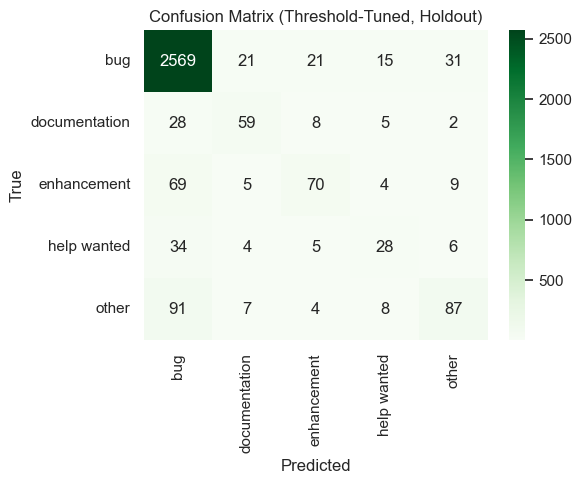

In [ ]:
from itertools import product

# Per-class threshold tuning on a validation split
Xt_train, Xt_val, yt_train, yt_val = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=42, stratify=y_train
)

pipe_for_tuning = Pipeline([
    ("union", union),
    ("clf", logreg_bal),
])
pipe_for_tuning.fit(Xt_train, yt_train)
proba_val = pipe_for_tuning.predict_proba(Xt_val)

# Optimize thresholds per class over a grid
classes_arr = np.array(sorted(pd.unique(y)))
idx_map = {c: i for i, c in enumerate(classes_arr)}

threshold_grid = np.linspace(0.2, 0.8, 13) 
best_f1 = -1.0
best_thresholds = np.array([0.5] * len(classes_arr))

for thresh_tuple in product(threshold_grid, repeat=len(classes_arr)):
    T = np.array(thresh_tuple)
    # Predict class with max(proba - threshold)
    adjusted = proba_val - T
    preds = classes_arr[np.argmax(adjusted, axis=1)]
    f1 = f1_score(yt_val, preds, average="macro")
    if f1 > best_f1:
        best_f1 = f1
        best_thresholds = T.copy()

print("Best macro-F1 on val with thresholds:", round(best_f1, 4))
print("Thresholds per class:")
for c, t in zip(classes_arr, best_thresholds):
    print(f"  {c}: {t:.2f}")

# Evaluate thresholds on the true test split
proba_test = pipe_for_tuning.predict_proba(X_test_text)
adjusted_test = proba_test - best_thresholds
preds_test = classes_arr[np.argmax(adjusted_test, axis=1)]
print("\nThreshold-tuned holdout report:")
print(classification_report(y_test, preds_test, digits=3))

cm_thr = confusion_matrix(y_test, preds_test, labels=classes_arr)
plt.figure(figsize=(6,5))
sns.heatmap(cm_thr, annot=True, fmt="d", cmap="Greens", xticklabels=classes_arr, yticklabels=classes_arr)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Threshold-Tuned, Holdout)")
plt.tight_layout()
plt.show()


Oversampled (train) union LogReg holdout report:
               precision    recall  f1-score   support

          bug      0.925     0.966     0.945      2657
documentation      0.646     0.608     0.626       102
  enhancement      0.538     0.497     0.517       157
  help wanted      0.585     0.312     0.407        77
        other      0.677     0.457     0.545       197

     accuracy                          0.884      3190
    macro avg      0.674     0.568     0.608      3190
 weighted avg      0.873     0.884     0.876      3190



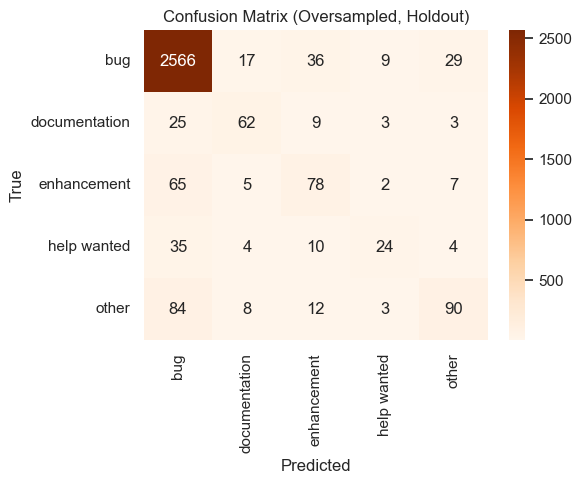

In [17]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# RandomOverSampler experiment on training data with union features
sampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)

imb_union_logreg = ImbPipeline([
    ("union", union),
    ("ros", sampler),
    ("clf", logreg_bal),
])

imb_union_logreg.fit(X_train_text, y_train)
preds_ros = imb_union_logreg.predict(X_test_text)
print("Oversampled (train) union LogReg holdout report:")
print(classification_report(y_test, preds_ros, digits=3))

# Use the classifier's class order for consistency
classes_ros = imb_union_logreg.named_steps["clf"].classes_
cm_ros = confusion_matrix(y_test, preds_ros, labels=classes_ros)

plt.figure(figsize=(6,5))
sns.heatmap(cm_ros, annot=True, fmt="d", cmap="Oranges",
            xticklabels=classes_ros, yticklabels=classes_ros)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Oversampled, Holdout)")
plt.tight_layout()
plt.show()

## Oversampling + per-class threshold tuning
We combine RandomOverSampler with the token+char TF-IDF union and tune per-class thresholds on a validation split to optimize macro-F1, then evaluate on the test split.


Best macro-F1 (val) with OS+thresholds: 0.6636
{np.str_('bug'): np.float64(0.45), np.str_('documentation'): np.float64(0.7), np.str_('enhancement'): np.float64(0.45), np.str_('help wanted'): np.float64(0.2), np.str_('other'): np.float64(0.4)}

OS + threshold-tuned holdout report:
               precision    recall  f1-score   support

          bug      0.926     0.964     0.944      2657
documentation      0.641     0.490     0.556       102
  enhancement      0.544     0.516     0.529       157
  help wanted      0.438     0.364     0.397        77
        other      0.652     0.437     0.523       197

     accuracy                          0.880      3190
    macro avg      0.640     0.554     0.590      3190
 weighted avg      0.869     0.880     0.872      3190



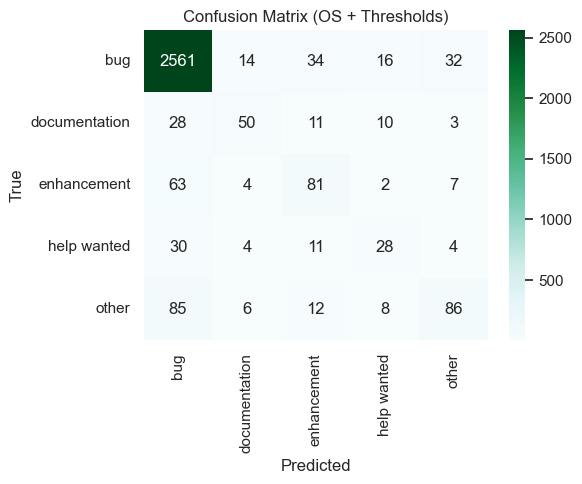

In [19]:
from imblearn.over_sampling import RandomOverSampler

# Split train into (train, val) for threshold tuning
Xt_train_os, Xt_val_os, yt_train_os, yt_val_os = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Pipeline: union features -> oversample -> logistic regression
os_sampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
os_union_logreg = ImbPipeline([
    ("union", union),
    ("ros", os_sampler),
    ("clf", logreg_bal),
])

os_union_logreg.fit(Xt_train_os, yt_train_os)
proba_val_os = os_union_logreg.predict_proba(Xt_val_os)

classes_os = os_union_logreg.named_steps["clf"].classes_
classes_os = np.array(sorted(classes_os))  # ensure sorted order for stability

# Reorder probabilities to match sorted classes if needed
orig_order = os_union_logreg.named_steps["clf"].classes_
if not np.array_equal(classes_os, orig_order):
    reorder_idx = [list(orig_order).index(c) for c in classes_os]
    proba_val_os = proba_val_os[:, reorder_idx]

# Grid search thresholds
th_grid = np.linspace(0.2, 0.8, 13)
best_f1_os, best_T_os = -1.0, np.array([0.5] * len(classes_os))
for t0 in th_grid:
    for t1 in th_grid:
        for t2 in th_grid:
            for t3 in th_grid:
                for t4 in th_grid:
                    T = np.array([t0, t1, t2, t3, t4])
                    preds = classes_os[np.argmax(proba_val_os - T, axis=1)]
                    f1 = f1_score(yt_val_os, preds, average="macro")
                    if f1 > best_f1_os:
                        best_f1_os, best_T_os = f1, T

print("Best macro-F1 (val) with OS+thresholds:", round(best_f1_os, 4))
print({c: round(t, 2) for c, t in zip(classes_os, best_T_os)})

# Evaluate on test
proba_test_os = os_union_logreg.predict_proba(X_test_text)
if not np.array_equal(classes_os, orig_order):
    proba_test_os = proba_test_os[:, reorder_idx]

preds_test_os = classes_os[np.argmax(proba_test_os - best_T_os, axis=1)]
print("\nOS + threshold-tuned holdout report:")
print(classification_report(y_test, preds_test_os, digits=3))

cm_os = confusion_matrix(y_test, preds_test_os, labels=classes_os)
plt.figure(figsize=(6,5))
sns.heatmap(cm_os, annot=True, fmt="d", cmap="BuGn", xticklabels=classes_os, yticklabels=classes_os)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (OS + Thresholds)")
plt.tight_layout()
plt.show()


## Targeted oversampling ratios
We oversample only minority classes to a fraction of the majority count (e.g., 0.6× bug size), fit the union + LogReg, and evaluate.


Sampling strategy (target counts): {'other': 6375, 'enhancement': 6375, 'documentation': 6375, 'help wanted': 6375}

Targeted oversampling (argmax) holdout report:
               precision    recall  f1-score   support

          bug      0.924     0.968     0.945      2657
documentation      0.629     0.598     0.613       102
  enhancement      0.545     0.497     0.520       157
  help wanted      0.571     0.312     0.403        77
        other      0.704     0.447     0.547       197

     accuracy                          0.885      3190
    macro avg      0.675     0.564     0.606      3190
 weighted avg      0.874     0.885     0.876      3190

Best macro-F1 (val) targeted OS + thresholds: 0.6602
{np.str_('bug'): np.float64(0.35), np.str_('documentation'): np.float64(0.55), np.str_('enhancement'): np.float64(0.5), np.str_('help wanted'): np.float64(0.2), np.str_('other'): np.float64(0.3)}

Targeted OS + threshold-tuned holdout report:
               precision    recall  f1-sco

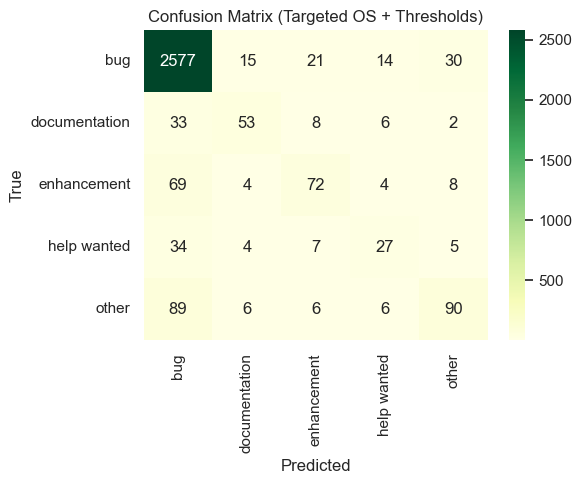

In [ ]:
# Compute class sizes on the training split
train_counts = y_train.value_counts()
majority_class = train_counts.idxmax()
majority_n = int(train_counts.max())

# Target ~60% of majority for minorities
target_ratio = 0.6
sampling_dict = {}
for c, n in train_counts.items():
    if c == majority_class:
        continue
    desired = int(majority_n * target_ratio)
    if desired > n:
        sampling_dict[c] = desired

print("Sampling strategy (target counts):", sampling_dict)

ros_targeted = RandomOverSampler(sampling_strategy=sampling_dict, random_state=42)

imb_union_logreg_targeted = ImbPipeline([
    ("union", union),
    ("ros", ros_targeted),
    ("clf", logreg_bal),
])

imb_union_logreg_targeted.fit(X_train_text, y_train)
proba_test_tar = imb_union_logreg_targeted.predict_proba(X_test_text)
classes_tar = imb_union_logreg_targeted.named_steps["clf"].classes_
print("\nTargeted oversampling (argmax) holdout report:")
print(classification_report(y_test, classes_tar[np.argmax(proba_test_tar, axis=1)], digits=3))

Xt_train_tar, Xt_val_tar, yt_train_tar, yt_val_tar = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=42, stratify=y_train
)
imb_union_logreg_targeted.fit(Xt_train_tar, yt_train_tar)
proba_val_tar = imb_union_logreg_targeted.predict_proba(Xt_val_tar)
classes_tar = np.array(sorted(imb_union_logreg_targeted.named_steps["clf"].classes_))

# Reorder if needed
orig_tar = imb_union_logreg_targeted.named_steps["clf"].classes_
if not np.array_equal(classes_tar, orig_tar):
    reorder_tar = [list(orig_tar).index(c) for c in classes_tar]
    proba_val_tar = proba_val_tar[:, reorder_tar]

th_grid = np.linspace(0.2, 0.8, 13)
best_f1_tar, best_T_tar = -1.0, np.array([0.5] * len(classes_tar))
for t0 in th_grid:
    for t1 in th_grid:
        for t2 in th_grid:
            for t3 in th_grid:
                for t4 in th_grid:
                    T = np.array([t0, t1, t2, t3, t4])
                    preds = classes_tar[np.argmax(proba_val_tar - T, axis=1)]
                    f1 = f1_score(yt_val_tar, preds, average="macro")
                    if f1 > best_f1_tar:
                        best_f1_tar, best_T_tar = f1, T

print("Best macro-F1 (val) targeted OS + thresholds:", round(best_f1_tar, 4))
print({c: round(t, 2) for c, t in zip(classes_tar, best_T_tar)})

proba_test_tar2 = imb_union_logreg_targeted.predict_proba(X_test_text)
if not np.array_equal(classes_tar, orig_tar):
    proba_test_tar2 = proba_test_tar2[:, reorder_tar]

y_pred_tar2 = classes_tar[np.argmax(proba_test_tar2 - best_T_tar, axis=1)]
print("\nTargeted OS + threshold-tuned holdout report:")
print(classification_report(y_test, y_pred_tar2, digits=3))

cm_tar = confusion_matrix(y_test, y_pred_tar2, labels=classes_tar)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tar, annot=True, fmt="d", cmap="YlGn", xticklabels=classes_tar, yticklabels=classes_tar)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Targeted OS + Thresholds)")
plt.tight_layout()
plt.show()


## Persist champion pipeline for Streamlit
Save the oversampled union TF-IDF + LogisticRegression pipeline, along with class order and simple metadata, to the `models/` directory.


In [ ]:
import joblib
from datetime import datetime

MODELS_DIR = "/Users/christian/dev/projects/semantica/models"
os.makedirs(MODELS_DIR, exist_ok=True)

champion_path = os.path.join(MODELS_DIR, "champion_union_logreg_os.joblib")
joblib.dump(imb_union_logreg, champion_path)
print("Saved champion pipeline to:", champion_path)

# Save class order and simple metadata
classes_champ = imb_union_logreg.named_steps["clf"].classes_.tolist()
metadata = {
    "saved_at": datetime.utcnow().isoformat() + "Z",
    "pipeline": "union(token tfidf 1-2; char tfidf 3-5 sublinear) + ROS + LogisticRegression",
    "class_weight": "balanced",
    "oversampling": "not majority",
    "classes": classes_champ,
}

with open(os.path.join(MODELS_DIR, "champion_metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)
print("Saved metadata.")


Saved champion pipeline to: /Users/christian/dev/projects/semantica/models/champion_union_logreg_os.joblib
Saved metadata.
